<a href="https://colab.research.google.com/github/skolouri/TinyTransformer/blob/main/TinyTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimal Transformer Encoder–Decoder

In this notebook, we build a minimal Transformer with both an encoder and a decoder:
- **Encoder:** Processes the source sequence.
- **Decoder:** Uses masked self-attention (to preserve causality) and cross-attention (to attend to the encoder output) to generate the target sequence.

We'll use sinusoidal positional encoding and basic modules (Multi-Head Attention and Feedforward networks) with residual connections and layer normalization. Finally, we test the model using dummy source and target token sequences.


## Building A Transformer One Block at a Time

### Setup and Imports

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math

# Check if GPU is available and set device accordingly (optional)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


### Positional Encoding

Positional Encoding output shape: torch.Size([2, 10, 128])


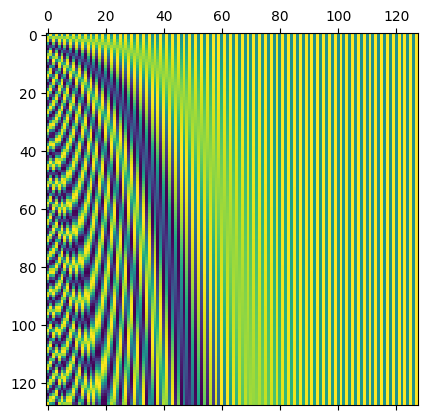

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        d_model: Dimensionality of the embeddings.
        max_len: Maximum length of the input sequences.
        """
        super().__init__()
        # Create a matrix of shape (max_len, d_model) with sinusoidal values
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices: sine
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices: cosine
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, d_model)
        Returns: x with positional encodings added.
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

# Test PositionalEncoding with dummy data
dummy_input = torch.zeros(2, 10, 128)  # batch_size=2, seq_len=10, d_model=32
pos_enc = PositionalEncoding(128)
print("Positional Encoding output shape:", pos_enc(dummy_input).shape)
plt.matshow(pos_enc.pe.squeeze()[:128,:])
plt.show()

### Multi-Head Attention

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        # Linear projections
        Q = self.W_q(query)  # (batch_size, seq_len, d_model)
        K = self.W_k(key)
        V = self.W_v(value)

        # Split into multiple heads and transpose for attention: (batch_size, num_heads, seq_len, d_k)
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            # Expect mask of shape (seq_len, seq_len) or broadcastable to (batch_size, num_heads, seq_len, seq_len)
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = torch.softmax(scores, dim=-1)
        out = torch.matmul(attention, V)

        # Concatenate attention heads and run through final linear layer
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.fc(out)

# Quick test:
dummy_input = torch.rand(2, 10, 32)
mha = MultiHeadAttention(d_model=32, num_heads=4)
print("MultiHeadAttention output shape:", mha(dummy_input, dummy_input, dummy_input).shape)


MultiHeadAttention output shape: torch.Size([2, 10, 32])


### Feedforward Network

In [5]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        '''
        MLP with d_ff hidden units and dropout.
        d_model: Input dimension.
        d_ff: Hidden layer dimension.
        dropout: Dropout rate.
        '''
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# Quick test:
ffn = FeedForward(d_model=32, d_ff=64)
print("FeedForward output shape:", ffn(dummy_input).shape)


FeedForward output shape: torch.Size([2, 10, 32])


### Transformer Encoder Layer

In [6]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Multi-head attention with residual connection and layer normalization
        attn_output = self.mha(x, x, x, mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        # Feedforward network with residual connection and layer normalization
        ffn_output = self.ffn(x)
        x = x + self.dropout2(ffn_output)
        x = self.norm2(x)
        return x

# Quick test:
encoder_layer = TransformerEncoderLayer(d_model=32, num_heads=4, d_ff=64)
print("Encoder Layer output shape:", encoder_layer(dummy_input).shape)


Encoder Layer output shape: torch.Size([2, 10, 32])


### Transformer Decoder Layer

In [7]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        # Decoder's masked self-attention
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        # Cross-attention: queries come from decoder, keys & values from encoder
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, encoder_output, self_mask=None, cross_mask=None):
        # Masked self-attention (ensure each position can only attend to previous positions)
        self_attn_output = self.self_attn(x, x, x, self_mask)
        x = x + self.dropout1(self_attn_output)
        x = self.norm1(x)

        # Cross-attention with encoder output (keys and values come from encoder)
        cross_attn_output = self.cross_attn(x, encoder_output, encoder_output, cross_mask)
        x = x + self.dropout2(cross_attn_output)
        x = self.norm2(x)

        # Feedforward network with residual connection
        ffn_output = self.ffn(x)
        x = x + self.dropout3(ffn_output)
        x = self.norm3(x)
        return x

# Quick test with dummy encoder output:
dummy_encoder_output = torch.rand(2,16, 32)
decoder_layer = TransformerDecoderLayer(d_model=32, num_heads=4, d_ff=64)
print("Decoder Layer output shape:", decoder_layer(dummy_input, dummy_encoder_output).shape)


Decoder Layer output shape: torch.Size([2, 10, 32])


###  Utility – Causal Mask Generation

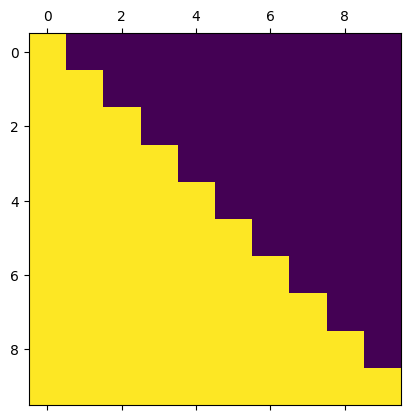

In [8]:
def generate_causal_mask(seq_len):
    """
    Generates a lower-triangular matrix of ones (allowed positions)
    and zeros in the upper triangle (masked positions).

    Returns:
        mask: Tensor of shape (seq_len, seq_len)
    """
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask  # This mask will be broadcasted appropriately in attention computations.

# Quick test:
mask = generate_causal_mask(10)
plt.matshow(mask)
plt.show()


### Encoder and Decoder Stacks

In [9]:
# Transformer Encoder and Decoder Stacks
# ----------------------------------------
# These classes create stacks of encoder and decoder layers, respectively.
# The encoder and decoder layers (TransformerEncoderLayer and TransformerDecoderLayer)
# are assumed to be defined in previous cells.
#
# The stacks allow us to build deeper transformer models by repeating the same layer multiple times.
# Finally, a LayerNorm is applied to the final output to stabilize and normalize the activations.

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        """
        Initializes a Transformer Encoder stack.

        Args:
            num_layers (int): Number of encoder layers to stack.
            d_model (int): Dimensionality of the input embeddings.
            num_heads (int): Number of attention heads in each encoder layer.
            d_ff (int): Dimensionality of the feedforward network within each encoder layer.
            dropout (float): Dropout probability for regularization.
        """
        super().__init__()
        # Create a list (ModuleList) of TransformerEncoderLayer instances.
        # Each layer in the list is identical in structure but has its own learnable parameters.
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        # Apply layer normalization at the end of the encoder stack.
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        """
        Pass the input through all encoder layers, sequentially.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len, d_model).
            mask (Tensor, optional): Attention mask to be applied in each encoder layer.

        Returns:
            Tensor: The normalized output of the encoder stack.
        """
        # Iterate over each encoder layer and update the input x.
        for layer in self.layers:
            x = layer(x, mask)
        # Normalize the final output.
        return self.norm(x)

class TransformerDecoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        """
        Initializes a Transformer Decoder stack.

        Args:
            num_layers (int): Number of decoder layers to stack.
            d_model (int): Dimensionality of the input embeddings.
            num_heads (int): Number of attention heads in each decoder layer.
            d_ff (int): Dimensionality of the feedforward network within each decoder layer.
            dropout (float): Dropout probability for regularization.
        """
        super().__init__()
        # Create a list (ModuleList) of TransformerDecoderLayer instances.
        # Each decoder layer handles both masked self-attention and cross-attention with encoder outputs.
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        # Apply layer normalization at the end of the decoder stack.
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, self_mask=None, cross_mask=None):
        """
        Pass the input through the decoder stack, incorporating encoder output.

        Args:
            x (Tensor): Decoder input tensor of shape (batch_size, tgt_seq_len, d_model).
            encoder_output (Tensor): Encoder output to be used for cross-attention.
            self_mask (Tensor, optional): Causal mask for the decoder's self-attention.
            cross_mask (Tensor, optional): Mask for the cross-attention (if needed).

        Returns:
            Tensor: The normalized output of the decoder stack.
        """
        # Iterate over each decoder layer and update the decoder's hidden state x.
        for layer in self.layers:
            x = layer(x, encoder_output, self_mask, cross_mask)
        # Normalize the final output.
        return self.norm(x)

print("\nTesting TransformerEncoder (Stack)...")
encoder_stack = TransformerEncoder(num_layers=2, d_model=32, num_heads=4, d_ff=64)
encoder_stack_out = encoder_stack(dummy_input)
assert encoder_stack_out.shape == dummy_input.shape, f"Expected shape {dummy_input.shape}, got {encoder_stack_out.shape}"
print("TransformerEncoder stack test passed:", encoder_stack_out.shape)

print("\nTesting TransformerDecoder (Stack)...")
dummy_decoder_input = torch.rand(2, 16, 32)
decoder_stack = TransformerDecoder(num_layers=2, d_model=32, num_heads=4, d_ff=64)
# Generate a causal mask for the decoder's self-attention.
# This mask prevents a position from attending to subsequent positions.
dummy_self_mask = generate_causal_mask(16)  # shape: (10, 10)
# For cross-attention, let's assume no masking is needed for simplicity.
# Alternatively, you could create a mask that marks padded tokens in the encoder output.
dummy_cross_mask = torch.ones(16, 10)  # All ones (no masking effect)
# Forward pass through the decoder stack with both self and cross attention masks applied
decoder_stack_out = decoder_stack(dummy_decoder_input, encoder_stack_out,
                                  self_mask=dummy_self_mask, cross_mask=dummy_cross_mask)

assert decoder_stack_out.shape == dummy_decoder_input.shape, \
    f"Expected shape {dummy_decoder_input.shape}, got {decoder_stack_out.shape}"
print("TransformerDecoder stack test with masks passed:", decoder_stack_out.shape)


Testing TransformerEncoder (Stack)...
TransformerEncoder stack test passed: torch.Size([2, 10, 32])

Testing TransformerDecoder (Stack)...
TransformerDecoder stack test with masks passed: torch.Size([2, 16, 32])


In [10]:
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1, max_len=5000):
        super().__init__()
        self.d_model = d_model

        # Embedding layers for source and target
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # Positional Encoding (shared for src and tgt)
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        # Encoder and Decoder stacks
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.decoder = TransformerDecoder(num_layers, d_model, num_heads, d_ff, dropout)

        # Generator: Final linear projection to produce logits for each vocabulary token
        self.generator = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """
        Args:
            src: Tensor of shape (batch_size, src_seq_len)
            tgt: Tensor of shape (batch_size, tgt_seq_len)
            src_mask: Optional mask for the source sequence (e.g., padding mask)
            tgt_mask: Optional mask for the target sequence (e.g., causal mask for self-attention)
        Returns:
            output: Logits of shape (batch_size, tgt_seq_len, tgt_vocab_size)
        """
        # Embed and scale the source tokens, then add positional encoding
        src_embedded = self.src_embedding(src) * math.sqrt(self.d_model)
        src_encoded = self.positional_encoding(src_embedded)
        encoder_output = self.encoder(src_encoded, src_mask)

        # Embed and scale the target tokens, then add positional encoding
        tgt_embedded = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        tgt_encoded = self.positional_encoding(tgt_embedded)
        decoder_output = self.decoder(tgt_encoded, encoder_output, self_mask=tgt_mask, cross_mask=src_mask)

        # Generate logits for each token in the target vocabulary
        output = self.generator(decoder_output)
        return output

# For clarity, print a summary of the model (using dummy parameters)
src_vocab_size = 100  # Example vocab size for source
tgt_vocab_size = 100  # Example vocab size for target
d_model = 32
num_layers = 2
num_heads = 4
d_ff = 64

model = TransformerModel(src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff).to(device)
print(model)


TransformerModel(
  (src_embedding): Embedding(100, 32)
  (tgt_embedding): Embedding(100, 32)
  (positional_encoding): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (mha): MultiHeadAttention(
          (W_q): Linear(in_features=32, out_features=32, bias=True)
          (W_k): Linear(in_features=32, out_features=32, bias=True)
          (W_v): Linear(in_features=32, out_features=32, bias=True)
          (fc): Linear(in_features=32, out_features=32, bias=True)
        )
        (ffn): FeedForward(
          (linear1): Linear(in_features=32, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=32, bias=True)
        )
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): 

### Complete Transformer Model

In [11]:
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1, max_len=5000):
        super().__init__()
        self.d_model = d_model

        # Embedding layers for source and target
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # Positional Encoding (shared for src and tgt)
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        # Encoder and Decoder stacks
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.decoder = TransformerDecoder(num_layers, d_model, num_heads, d_ff, dropout)

        # Generator: Final linear projection to produce logits for each vocabulary token
        self.generator = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """
        Args:
            src: Tensor of shape (batch_size, src_seq_len)
            tgt: Tensor of shape (batch_size, tgt_seq_len)
            src_mask: Optional mask for the source sequence (e.g., padding mask)
            tgt_mask: Optional mask for the target sequence (e.g., causal mask for self-attention)
        Returns:
            output: Logits of shape (batch_size, tgt_seq_len, tgt_vocab_size)
        """
        # Embed and scale the source tokens, then add positional encoding
        src_embedded = self.src_embedding(src) * math.sqrt(self.d_model)
        src_encoded = self.positional_encoding(src_embedded)
        encoder_output = self.encoder(src_encoded, src_mask)

        # Embed and scale the target tokens, then add positional encoding
        tgt_embedded = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        tgt_encoded = self.positional_encoding(tgt_embedded)
        decoder_output = self.decoder(tgt_encoded, encoder_output, self_mask=tgt_mask, cross_mask=src_mask)

        # Generate logits for each token in the target vocabulary
        output = self.generator(decoder_output)
        return output

# For clarity, print a summary of the model (using dummy parameters)
src_vocab_size = 100  # Example vocab size for source
tgt_vocab_size = 100  # Example vocab size for target
d_model = 32
num_layers = 2
num_heads = 4
d_ff = 64

model = TransformerModel(src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff).to(device)
print(model)


TransformerModel(
  (src_embedding): Embedding(100, 32)
  (tgt_embedding): Embedding(100, 32)
  (positional_encoding): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (mha): MultiHeadAttention(
          (W_q): Linear(in_features=32, out_features=32, bias=True)
          (W_k): Linear(in_features=32, out_features=32, bias=True)
          (W_v): Linear(in_features=32, out_features=32, bias=True)
          (fc): Linear(in_features=32, out_features=32, bias=True)
        )
        (ffn): FeedForward(
          (linear1): Linear(in_features=32, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=32, bias=True)
        )
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): 

## Real NLP Example: Language Modeling on the Tiny Shakespeare Dataset

### Download and Read the Dataset

In [12]:
dataset_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
data_path = "shakespeare.txt"

if not os.path.exists(data_path):
    print("Downloading Tiny Shakespeare dataset...")
    # In Colab you can use !wget to download the file
    !wget -O shakespeare.txt {dataset_url}

# Read the entire dataset as a string.
with open(data_path, "r", encoding="utf-8") as f:
    text = f.read()

print(f"Dataset length: {len(text)} characters")

--2025-04-12 01:00:49--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   1.06M  --.-KB/s    in 0.005s  

2025-04-12 01:00:49 (204 MB/s) - ‘shakespeare.txt’ saved [1115394/1115394]

Dataset length: 1115394 characters


### Tokenizer - Character Level Tokenization

In [13]:
# Get the sorted list of unique characters.
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Unique characters (vocab size): {vocab_size}")

# Create mappings from character to index and vice-versa.
stoi = { ch: i for i, ch in enumerate(chars) }
itos = { i: ch for i, ch in enumerate(chars) }

def encode(s):
    """Encodes a string into a list of integers."""
    return [stoi[c] for c in s]

def decode(l):
    """Decodes a list of integers back into a string."""
    return "".join([itos[i] for i in l])

# Encode the entire text into a tensor of token ids.
data = torch.tensor(encode(text), dtype=torch.long)

Unique characters (vocab size): 65


### Create a Dataset and DataLoader for Training

In [40]:
# Define the context length for training examples.
# block_size is set to 512 meaning each training example will consist of 512 consecutive tokens.
# A larger block_size gives more context but also increases memory usage and computational cost.
block_size = 1024  # This is the sequence length for each training example
batch_size = 64
# Create a custom Dataset for the Tiny Shakespeare data
class ShakespeareDataset(Dataset):
    def __init__(self, data, block_size):
        """
        Args:
            data (Tensor): The tokenized text data as a 1D tensor of integers.
            block_size (int): The number of tokens in each training example (context length).
        """
        self.data = data
        self.block_size = block_size

    def __len__(self):
        # The length of the dataset is the number of starting positions from which we
        # can extract a full sequence of block_size tokens. We subtract block_size to ensure
        # that each training example has enough tokens (x and target y) to cover the full context.
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # For a given index 'idx', generate a training example:
        # x: The input sequence starting at index 'idx' and ending at idx+block_size.
        # y: The target sequence (ground truth) which is the same as x but shifted by 1 token.
        # This shifting means the model is trained to predict the next token for each input token.
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# Instantiate the dataset with the tokenized data and the specified block_size.
dataset = ShakespeareDataset(data, block_size)

# Create a DataLoader to handle batching and shuffling of the dataset.
# - shuffle=True ensures that the training examples are randomized on each epoch.
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


### Instantiate the Transformer Model

In [39]:
# Define hyperparameters for the model.
d_model = 768
num_layers = 8
num_heads = 8
d_ff = 256
dropout = 0.0

# Instantiate the TransformerModel.
# This model is our encoder-decoder transformer.
model = TransformerModel(
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    d_model=d_model,
    num_layers=num_layers,
    num_heads=num_heads,
    d_ff=d_ff,
    dropout=dropout
).to(device)

### Define Loss, Optimizer, and Training Loop

In [18]:
criterion = nn.CrossEntropyLoss()

fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
use_fused = fused_available and device_type == 'cuda'
extra_args = dict(fused=True) if use_fused else dict()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, betas=betas, **extra_args)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("\nStarting training...\n")
loss_log = []
epochs = 1  # For demonstration; you can increase the number of epochs if desired.
for epoch in range(epochs):
    running_loss = 0.0
    for i, (x, y) in enumerate(dataloader):
        # Move batch tensors to the device (CPU or GPU).
        x = x.to(device)  # x: (batch_size, block_size)
        y = y.to(device)  # y: (batch_size, block_size)

        # For language modeling we treat the sequence as both source and (shifted) target.
        src = x  # Encoder input
        tgt = x  # Decoder input (the target is implicitly given by y)

        # Create a causal mask for the decoder's self-attention.
        tgt_mask = generate_causal_mask(tgt.size(1)).to(device)

        optimizer.zero_grad()
        output = model(src, tgt, tgt_mask=tgt_mask)
        # output shape: (batch_size, block_size, vocab_size)

        # Compute loss: reshape output and target to match CrossEntropyLoss requirements.
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 1000 == 0:
            avg_loss = running_loss / 1000
            loss_log.append(avg_loss)
            print(f"Epoch {epoch+1}, Step {i+1}, Loss: {avg_loss:.4f}")
            running_loss = 0.0
    # Save the model's state dictionary to a file.
    model_save_path = "transformer_model_epoch_%d.pth"%(epoch+3)
    torch.save(model.state_dict(), model_save_path)
    print(f"Model state dictionary saved to {model_save_path}")
print("\nTraining complete.")


Starting training...


Training complete.


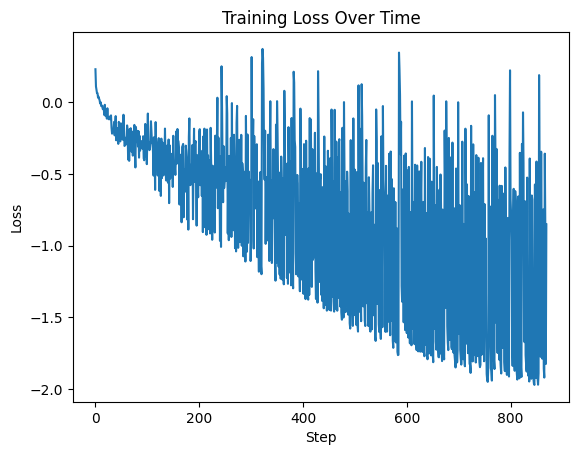

0.01066792112775147


In [32]:
plt.plot(np.log10(loss_log))
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()
print(min(loss_log))

In [19]:
# Save the model's state dictionary to a file.
model_save_path = "transformer_model_state_dict.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model state dictionary saved to {model_save_path}")

Model state dictionary saved to transformer_model_state_dict.pth


In [33]:
model.load_state_dict(torch.load("./transformer_model_epoch_2.pth"))

<All keys matched successfully>

In [37]:
def generate_text(model, prompt, max_new_tokens=200, temperature=1.0, eos_token=None):
    """
    Generate text using autoregressive sampling with the trained TransformerModel.

    This function uses the prompt as the encoder input and the generated sequence as the
    decoder input. At each step, it computes the logits for the next token, applies temperature
    scaling, converts logits to probabilities, and samples the next token from the distribution.

    Args:
        model: The trained TransformerModel.
        prompt (str): A seed text to start the generation.
        max_new_tokens (int): Maximum number of new tokens to generate.
        temperature (float): Temperature for scaling logits; values > 1.0 increase randomness.
        eos_token (int, optional): An optional end-of-sequence token id; if generated, stop decoding.

    Returns:
        str: The generated text.
    """
    model.eval()  # Set model to evaluation mode.
    # Convert the prompt to token ids and create a batch (shape: [1, seq_len]).
    input_ids = torch.tensor(encode(prompt), dtype=torch.long).unsqueeze(0).to(device)
    src = input_ids
    # Initialize the generated sequence with the prompt tokens.
    generated = input_ids.clone()

    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Use the entire generated sequence as decoder input.
            tgt = generated
            # Generate a causal mask for the current decoder sequence.
            tgt_mask = generate_causal_mask(tgt.size(1)).to(device)
            # Forward pass through the model.
            logits = model(src, tgt, tgt_mask=tgt_mask)
            # Scale the logits for the last token of the sequence.
            next_token_logits = logits[:, -1, :] / temperature
            # Convert logits to probabilities.
            probs = torch.softmax(next_token_logits, dim=-1)
            # Sample one token from the probability distribution.
            next_token = torch.multinomial(probs, num_samples=1)

            # Stop generation if the end-of-sequence token is produced.
            if eos_token is not None and next_token.item() == eos_token:
                break

            # Append the sampled token to the generated sequence.
            generated = torch.cat((generated, next_token), dim=1)

    # Decode the generated token ids back into text.
    output_text = decode(generated.squeeze().tolist())
    return output_text



# === 7. Generate and Display Text ===

seed_prompt = "ROMEO:"  # A simple starting prompt
generated_text = generate_text(model, seed_prompt, max_new_tokens=200)
print("\nGenerated Text:\n")
print(generated_text)


Generated Text:

ROMEO:EEEEEEEEZEEEEEEZEZEOZZZZZZEOZOEOZOZOZOZOZOEOqOqOq;ZOqOqqqOqqqqqqqu.RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRIUR:RRRRRRRRRRRRRRRRRRRRiRqRqR
qRq RaROqRo:RqRe:RqRe ROqRe:RqRqROqROqRqRqR R ROqRqRqRqRqRe:RqR


In [28]:
probs

NameError: name 'probs' is not defined